In [1]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, HTML, Markdown
import seaborn as sns
from time import time, strftime
import datetime
import openpyxl
import seaborn as sns
%matplotlib inline

In [2]:
start_time = time()

In [3]:
#Настройки отображения данных в ноутбуке
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
pd.options.mode.chained_assignment = None  # default='warn'
# pd.set_option('display.max_rows', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_colwidth', None)
plt.rcParams['figure.figsize'] = [10, 10]

In [9]:
def parse_date(s):
    try:
        dt = datetime.datetime.strptime(s, '%Y-%m-%d %H:%M:%S')
        if dt.year < 1900 or dt.year > 2100 or dt.month < 1 or dt.month > 12 or dt.day < 1 or dt.day > 31 or \
            dt.hour < 0 or dt.hour > 23 or dt.minute < 0 or dt.minute > 59 or dt.second < 0 or dt.second > 59:
            return None
        return dt
    except ValueError:
        return None

In [ ]:
RawTransactions = pd.read_csv('OTUS/fraud-data/2019-08-22_1.txt', sep=',', 
                   header=None,
                   low_memory=False,
                   skiprows=[0],                   
                   parse_dates=[1],
                   date_parser=parse_date,
                   names=['tranaction_id', 'tx_datetime', 'customer_id', 'terminal_id', 
                          'tx_amount', 'tx_time_seconds', 'tx_time_days', 'tx_fraud', 
                          'tx_fraud_scenario'])

RawTransactions['parsing_error'] = ''
RawTransactions['parsing_error'][RawTransactions['tx_datetime'].isna()] += "tx_datetime-error; "
duplicates = RawTransactions.duplicated(subset=['tranaction_id'], keep='first')
RawTransactions['parsing_error'][duplicates] += "duplicate tranaction_id; "
RawTransactions['parsing_error'][RawTransactions['tx_amount'] == 0] += "tx_amount=0; "
RawTransactions['parsing_error'][abs(RawTransactions['customer_id']) == 999999] += "customer_id=" + RawTransactions['customer_id'].astype(str) + "; "
RawTransactions['parsing_error'][(RawTransactions['terminal_id'] == 0) | (RawTransactions['terminal_id'] > 10000)] += "terminal_id=" + \
    RawTransactions['terminal_id'].astype(str) + "; "

RawTransactions

In [5]:
RawTransactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350000 entries, 0 to 349999
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   tranaction_id      350000 non-null  int64         
 1   tx_datetime        350000 non-null  datetime64[ns]
 2   customer_id        350000 non-null  int64         
 3   terminal_id        350000 non-null  int64         
 4   tx_amount          350000 non-null  float64       
 5   tx_time_seconds    350000 non-null  int64         
 6   tx_time_days       350000 non-null  int64         
 7   tx_fraud           350000 non-null  int64         
 8   tx_fraud_scenario  350000 non-null  int64         
 9   parsing_error      350000 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(7), object(1)
memory usage: 26.7+ MB


In [6]:
RawTransactions.describe()

,tranaction_id,customer_id,terminal_id,tx_amount,tx_time_seconds,tx_time_days,tx_fraud,tx_fraud_scenario
count,350000.000000,350000.000000,3.500000e+05,350000.000000,350000.000000,350000.0,350000.000000,350000.000000
mean,174999.500000,112222.782117,2.609973e+04,54.207721,43173.563640,0.0,0.054686,0.110169
std,101036.441445,64738.615279,1.512909e+06,41.629973,18194.575823,0.0,0.227366,0.460134
min,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.0,0.000000,0.000000
25%,87499.750000,56035.000000,1.990000e+02,21.930000,30149.750000,0.0,0.000000,0.000000
50%,174999.500000,112363.500000,5.130000e+02,45.430000,43179.000000,0.0,0.000000,0.000000
75%,262499.250000,168357.250000,7.970000e+02,77.762500,56171.000000,0.0,0.000000,0.000000
max,349999.000000,224263.000000,8.951810e+07,3044.270000,86397.000000,0.0,1.000000,3.000000


In [20]:
parsing_error = RawTransactions[RawTransactions['parsing_error'] != '']
parsing_error

,tranaction_id,tx_datetime,customer_id,terminal_id,tx_amount,tx_time_seconds,tx_time_days,tx_fraud,tx_fraud_scenario,parsing_error
1,1,2019-08-22 05:10:37,0,0,90.55,18637,0,0,0,terminal_id=0;
3,3,2019-08-22 07:21:33,0,0,80.41,26493,0,0,0,terminal_id=0;
6,6,2019-08-22 03:12:21,3,0,47.20,11541,0,0,0,terminal_id=0;
12,12,2019-08-22 15:47:54,10,0,58.89,56874,0,0,0,terminal_id=0;
69,69,2019-08-22 12:00:23,44,0,70.64,43223,0,0,0,terminal_id=0;
...,...,...,...,...,...,...,...,...,...,...
349961,349961,2019-08-22 18:03:07,224242,0,109.14,64987,0,0,0,terminal_id=0;
349972,349972,2019-08-22 23:54:35,224251,0,37.96,86075,0,0,0,terminal_id=0;
349977,349977,2019-08-22 12:50:21,224255,0,68.31,46221,0,0,0,terminal_id=0;
349979,349979,2019-08-22 09:39:13,224255,0,79.11,34753,0,0,0,terminal_id=0;


In [21]:
parsing_error.to_excel("parsing_error.xlsx", sheet_name="parsing_error", index=False)

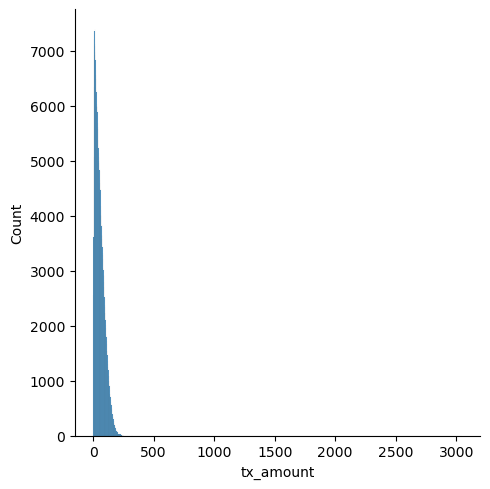

In [23]:
sns.displot(RawTransactions['tx_amount'])

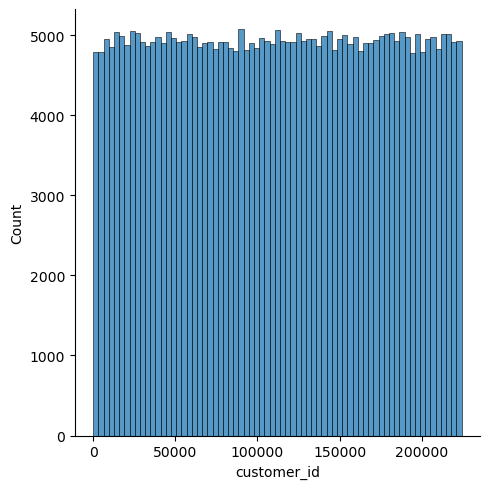

In [24]:
sns.displot(RawTransactions['customer_id'])

In [ ]:
RawTransactions['customer_id'].value_counts()

In [ ]:
sns.displot(RawTransactions['terminal_id'])

In [ ]:
RawTransactions['terminal_id'].value_counts()

In [ ]:
sns.displot(RawTransactions['tx_fraud'])

In [ ]:
RawTransactions['tx_fraud'].value_counts()

In [ ]:
sns.displot(RawTransactions['tx_fraud_scenario'])

In [ ]:
RawTransactions['tx_fraud_scenario].value_counts()

In [ ]:
sns.displot(RawTransactions['tx_time_seconds'])

In [ ]:
sns.displot(RawTransactions['tx_time_days'])